## TASK 4.1
Development of a classification model for discriminating the abnormality type (mass v calcification) using pre-trained or from-scratch CNN. The model must exploit the baseline patches (e.g. feeding model with both abnormality and baseline patches, siamese architecture, ...)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.x
import os
import itertools
import numpy as np
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task4_1') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 128

# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### Utility function definition

#### Loading training and test sets

In [ ]:
# Loading training set and test set
def load_training():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels


#### Plotting accuracy and loss trends

In [ ]:
# Utility function for plotting accuracy and loss function
def performance_plot(history, model, test_generator, test_labels):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  pred_labels = model.predict(test_generator)
  pred_labels = np.rint(pred_labels)

  print(classification_report(test_labels, pred_labels, digits=4))

#### Plotting the confusion matrix

In [ ]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

### Dataset creation
We take the original dataset with five labels: we discard the label '0', which correspond to baseline patch, because we are considering only the abnormalities, and we aggregate label '1' and '2', which both correspond to masses, and label '3' and '4', which are both calcifications.


In [ ]:
train_img, train_lab = load_training()
test_img, test_lab = load_test()
# Training set
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

base_images = train_img[0::2].reshape((2676, 150, 150, 1)).astype('float32') / 65535

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') / 65535

abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 2] = 0
abnormality_labels[abnormality_labels == 3] = 1
abnormality_labels[abnormality_labels == 4] = 1

print("Original training set")
print(abnormality_labels.shape)
print(abnormality_images.shape)

# join base image and abnormaliy images
abnormality_images = np.expand_dims(abnormality_images, axis=1)
base_images = np.expand_dims(base_images, axis=1)
abnormality_images = np.hstack((abnormality_images, base_images))
print("After joining with base images")
print(abnormality_images.shape)

# Validation set
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)

print("Training set")
print(train_labels.shape)
print(train_images.shape)
print("Validation set")
print(valid_labels.shape)
print(valid_images.shape)


# Test set
test_images = test_img[1::2]
test_labels = test_lab[1::2]
test_base_images = test_img[0::2].reshape((336, 150, 150, 1)).astype('float32') / 65535

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') / 65535

test_labels[test_labels == 1] = 0
test_labels[test_labels == 2] = 0
test_labels[test_labels == 3] = 1
test_labels[test_labels == 4] = 1


print("Test set")
print(test_labels.shape)
print(test_images.shape)

# join base image and abnormaliy images
test_images = np.expand_dims(test_images, axis=1)
test_base_images = np.expand_dims(test_base_images, axis=1)
test_images = np.hstack((test_images, test_base_images))
print("After joining with base images")
print(test_images.shape)

Original training set
(2676,)
(2676, 150, 150, 1)
After joining with base images
(2676, 2, 150, 150, 1)
Training set
(1873,)
(1873, 2, 150, 150, 1)
Validation set
(803,)
(803, 2, 150, 150, 1)
Test set
(336,)
(336, 150, 150, 1)
After joining with base images
(336, 2, 150, 150, 1)


### Siamese Network

#### Preprocessing
We perform Data Augmentation with the training set in order to increase the number of data. 

We consider geometric transformations, such as the rotation, the vertical and horizontal flip. We choose as fill mode the default value which fills the area with the nearest pixel and stretching it.

The rescaling is made to 65535 because the dataset is composed by 16 bit images.

In [ ]:
def get_data_gen(data, labels, data_gen_args = {}, seed = 1):
  datagen_abnormality = ImageDataGenerator(**data_gen_args)
  # Provide the same seed and keyword arguments to the fit and flow methods
  datagen_abnormality.fit(data[:,0,:,:,:], seed=seed)


  generator_abnormality = datagen_abnormality.flow(data[:,0,:,:,:], labels, batch_size=BATCH_SIZE, seed=seed)
  generator_base = datagen_abnormality.flow(data[:,1,:,:,:], labels, batch_size=BATCH_SIZE, seed=seed)

  # combine generators into one which yields image and masks
  while True:
    abnormality_image, label = generator_abnormality.next()
    base_image, _ = generator_base.next()
    yield [abnormality_image, base_image], label

In [ ]:
train_datagen_args = dict(
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True)

train_generator = get_data_gen(train_images, train_labels, train_datagen_args)

validation_generator = get_data_gen(valid_images, valid_labels)

#### Experiment 1


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         2378432     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[0][0]         

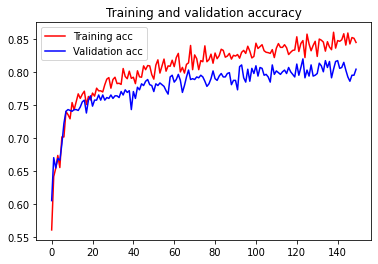

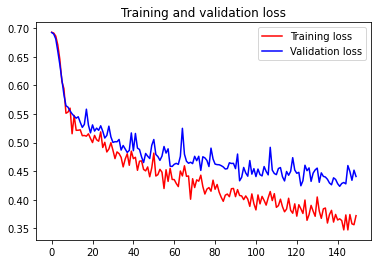

              precision    recall  f1-score   support

           0     0.8250    0.7374    0.7788       179
           1     0.7330    0.8217    0.7748       157

    accuracy                         0.7768       336
   macro avg     0.7790    0.7795    0.7768       336
weighted avg     0.7820    0.7768    0.7769       336



In [ ]:
input_shape = (150, 150, 1)
# Two input channels
left_input = layers.Input(shape=input_shape)
right_input = layers.Input(shape=input_shape)

# CNN core
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(4096, activation='sigmoid'))

# Feed both input into the same convolutional base
left_model = cnn(left_input)
right_model = cnn(right_input)

L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([left_model, right_model])

# Add a dense layer with a sigmoid unit to generate the prediction
prediction = layers.Dense(1, activation='sigmoid')(L1_distance)


# Instantiate the model
siamese = models.Model(inputs=[left_input, right_input], outputs=prediction)
siamese.summary()
siamese.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = siamese.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
siamese.load_weights('checkpoint.h5')
performance_plot(history, siamese, [test_images[:,0,:,:,:], test_images[:,1,:,:,:]], test_labels)
models.save_model(siamese, os.path.join(MODEL_PATH, 'siamese_1.h5'))

Specificity :  0.7374301675977654
Sensitivity :  0.821656050955414


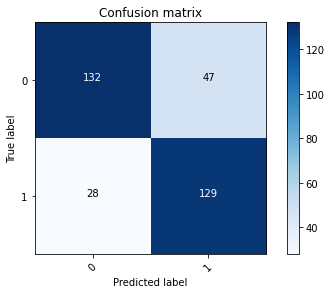

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'siamese_1.h5'))
pred = model.predict([test_images[:,0,:,:,:], test_images[:,1,:,:,:]])
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

### CNN 2D

#### Preprocessing
We perform Data Augmentation with the training set in order to increase the number of data. 

We consider geometric transformations, such as the rotation, the vertical and horizontal flip. We choose as fill mode the default value which fills the area with the nearest pixel and stretching it.

The rescaling is made to 65535 because the dataset is composed by 16 bit images.

In [ ]:
def get_data_gen(data, labels, data_gen_args = {}, seed = 1):
  datagen_abnormality = ImageDataGenerator(**data_gen_args)
  # Provide the same seed and keyword arguments to the fit and flow methods
  datagen_abnormality.fit(data[:,0,:,:,:], seed=seed)


  generator_abnormality = datagen_abnormality.flow(data[:,0,:,:,:], labels, batch_size=BATCH_SIZE, seed=seed)
  generator_base = datagen_abnormality.flow(data[:,1,:,:,:], labels, batch_size=BATCH_SIZE, seed=seed)

  # combine generators into one which yields image and masks
  while True:
    abnormality_image, label = generator_abnormality.next()
    base_image, _ = generator_base.next()
    yield np.stack((abnormality_image[:,:,:,0], base_image[:,:,:,0]), axis=-1), label


In [ ]:
train_datagen_args = dict(
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True)

train_generator = get_data_gen(train_images, train_labels, train_datagen_args)

validation_generator = get_data_gen(valid_images, valid_labels)

#### Experiment 1


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

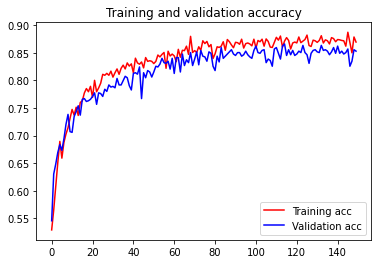

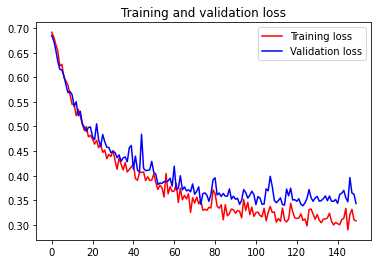

              precision    recall  f1-score   support

           0     0.8547    0.8547    0.8547       179
           1     0.8344    0.8344    0.8344       157

    accuracy                         0.8452       336
   macro avg     0.8446    0.8446    0.8446       336
weighted avg     0.8452    0.8452    0.8452       336



In [ ]:
input_shape = (150, 150, 2)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = model.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model.load_weights('checkpoint.h5')
performance_plot(history, model, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1), test_labels)
models.save_model(model, os.path.join(MODEL_PATH, 'model_2d.h5'))

Specificity :  0.8547486033519553
Sensitivity :  0.8343949044585988


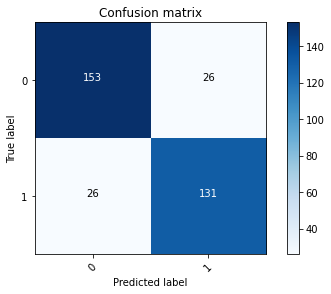

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'model_2d.h5'))
pred = model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1))
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

#### Experiment 2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      608       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

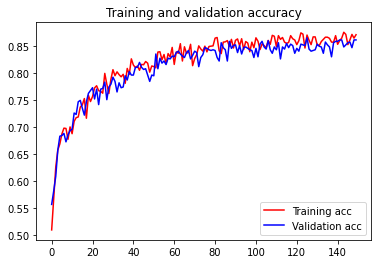

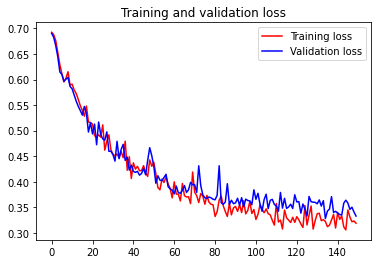

              precision    recall  f1-score   support

           0     0.8571    0.8380    0.8475       179
           1     0.8199    0.8408    0.8302       157

    accuracy                         0.8393       336
   macro avg     0.8385    0.8394    0.8388       336
weighted avg     0.8397    0.8393    0.8394       336



In [ ]:
input_shape = (150, 150, 2)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = model.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model.load_weights('checkpoint.h5')
performance_plot(history, model, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1), test_labels)
models.save_model(model, os.path.join(MODEL_PATH, 'model_2d_2.h5'))

Specificity :  0.8379888268156425
Sensitivity :  0.8407643312101911


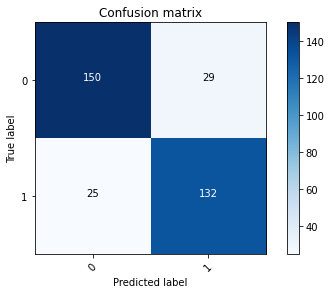

In [ ]:
model = model = models.load_model(os.path.join(MODEL_PATH, 'model_2d_2.h5'))
pred = model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1))
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

### CNN 3D

#### Preprocessing
We perform Data Augmentation with the training set in order to increase the number of data. 

We consider geometric transformations, such as the rotation, the vertical and horizontal flip. We choose as fill mode the default value which fills the area with the nearest pixel and stretching it.


In [ ]:
def get_data_gen(data, labels, data_gen_args = {}, seed = 1):
  datagen_abnormality = ImageDataGenerator(**data_gen_args)
  # Provide the same seed and keyword arguments to the fit and flow methods
  datagen_abnormality.fit(data[:,0,:,:,:], seed=seed)


  generator_abnormality = datagen_abnormality.flow(data[:,0,:,:,:], labels, batch_size=BATCH_SIZE, seed=seed)
  generator_base = datagen_abnormality.flow(data[:,1,:,:,:], labels, batch_size=BATCH_SIZE, seed=seed)

  # combine generators into one which yields image and masks
  while True:
    abnormality_image, label = generator_abnormality.next()
    base_image, _ = generator_base.next()

    yield np.stack((abnormality_image[:,:,:,0], base_image[:,:,:,0]), axis=-1)[:,:,:,:,np.newaxis], label

In [ ]:
train_datagen_args = dict(
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True)

train_generator = get_data_gen(train_images, train_labels, train_datagen_args)

validation_generator = get_data_gen(valid_images, valid_labels)

In [ ]:
for t ,_ in train_generator:
  print(t.shape)
  break

(128, 150, 150, 2, 1)


#### Experiment 1


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 148, 148, 2, 32)   320       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 74, 74, 2, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 72, 72, 2, 64)     18496     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 36, 36, 2, 64)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 34, 34, 2, 64)     36928     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 17, 17, 2, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 15, 15, 2, 128)   

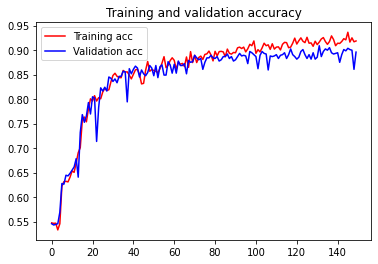

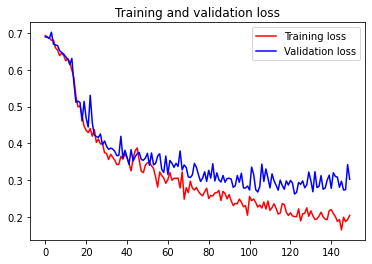

              precision    recall  f1-score   support

           0     0.9024    0.8268    0.8630       179
           1     0.8198    0.8981    0.8571       157

    accuracy                         0.8601       336
   macro avg     0.8611    0.8625    0.8601       336
weighted avg     0.8638    0.8601    0.8602       336



In [ ]:
input_shape = (150, 150, 2, 1)
model = models.Sequential()
model.add(layers.Conv3D(32, (3, 3, 1), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(128, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(256, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = model.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model.load_weights('checkpoint.h5')
performance_plot(history, model, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis], test_labels)
models.save_model(model, os.path.join(MODEL_PATH, 'model_3d.h5'))

Specificity :  0.8268156424581006
Sensitivity :  0.8980891719745223


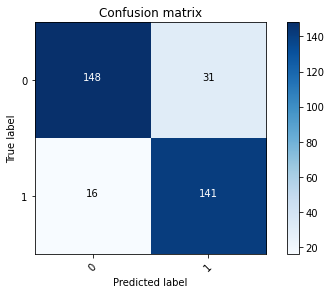

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'model_3d.h5'))
pred = model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

#### Experiment 2

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 148, 148, 2, 32)   320       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 74, 74, 2, 32)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 72, 72, 2, 64)     18496     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 36, 36, 2, 64)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 34, 34, 2, 64)     36928     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 17, 17, 2, 64)     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 15, 15, 2, 128)   

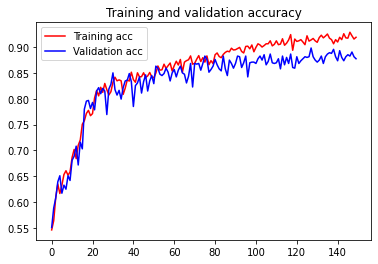

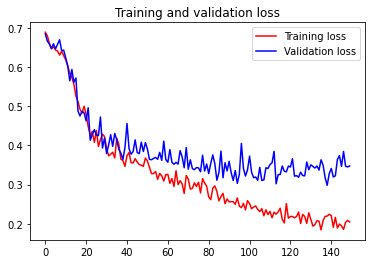

              precision    recall  f1-score   support

           0     0.8698    0.8212    0.8448       179
           1     0.8084    0.8599    0.8333       157

    accuracy                         0.8393       336
   macro avg     0.8391    0.8406    0.8391       336
weighted avg     0.8411    0.8393    0.8395       336



In [ ]:
input_shape = (150, 150, 2, 1)
model = models.Sequential()
model.add(layers.Conv3D(32, (3, 3, 1), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(128, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(256, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = model.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model.load_weights('checkpoint.h5')
performance_plot(history, model, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis], test_labels)
models.save_model(model, os.path.join(MODEL_PATH, 'model_3d_2.h5'))

Specificity :  0.8212290502793296
Sensitivity :  0.8598726114649682


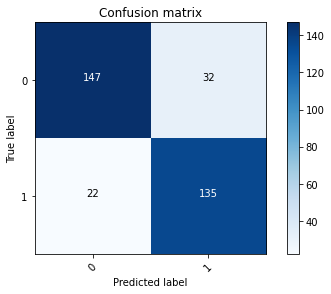

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'model_3d_2.h5'))
pred = model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

#### Experiment 3 (Combine channel con conv)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 148, 148, 2, 32)   320       
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 74, 74, 2, 32)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 72, 72, 2, 64)     18496     
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 36, 36, 2, 64)     0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 34, 34, 2, 128)    73856     
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 17, 17, 2, 128)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 15, 2, 256)   

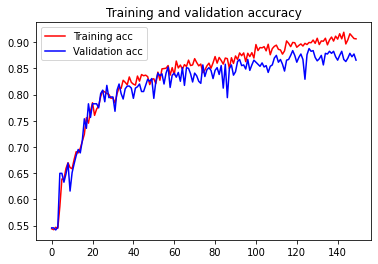

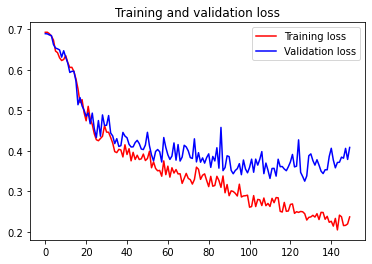

              precision    recall  f1-score   support

           0     0.8810    0.8268    0.8530       179
           1     0.8155    0.8726    0.8431       157

    accuracy                         0.8482       336
   macro avg     0.8482    0.8497    0.8481       336
weighted avg     0.8504    0.8482    0.8484       336



In [ ]:
input_shape = (150, 150, 2, 1)
model = models.Sequential()
model.add(layers.Conv3D(32, (3, 3, 1), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(128, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(256, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(512, (3, 3, 2), activation='relu')) # merge the 2 channel
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = model.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model.load_weights('checkpoint.h5')
performance_plot(history, model, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis], test_labels)
models.save_model(model, os.path.join(MODEL_PATH, 'model_3d_3.h5'))

Specificity :  0.8268156424581006
Sensitivity :  0.8726114649681529


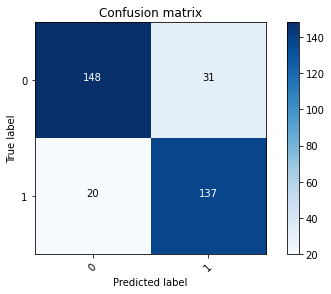

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'model_3d_3.h5'))
pred = model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

#### Experiment 4 (Experiment 1 seems the better, try to improve)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 148, 148, 2, 64)   640       
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 74, 74, 2, 64)     0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 72, 72, 2, 64)     36928     
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 36, 36, 2, 64)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 34, 34, 2, 128)    73856     
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 17, 17, 2, 128)    0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 15, 15, 2, 128)   

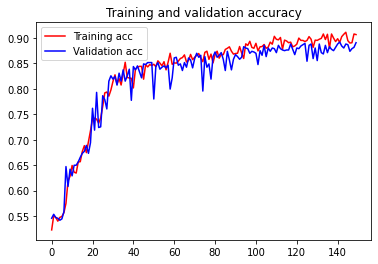

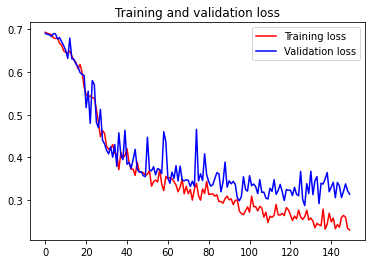

              precision    recall  f1-score   support

           0     0.8564    0.8659    0.8611       179
           1     0.8452    0.8344    0.8397       157

    accuracy                         0.8512       336
   macro avg     0.8508    0.8502    0.8504       336
weighted avg     0.8511    0.8512    0.8511       336



In [ ]:
input_shape = (150, 150, 2, 1)
model = models.Sequential()
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(64, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(128, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(128, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Conv3D(256, (3, 3, 1), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 1)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

model_checkpoint = ModelCheckpoint('checkpoint.h5', save_best_only=True, save_weights_only=True, verbose=1)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=50)

history = model.fit(
  train_generator,
  steps_per_epoch = len(train_images) // BATCH_SIZE,
  epochs=150,
  validation_data = validation_generator,
  validation_steps =  len(valid_images) // BATCH_SIZE,
  callbacks = [callback, model_checkpoint]
  )
model.load_weights('checkpoint.h5')
performance_plot(history, model, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis], test_labels)
models.save_model(model, os.path.join(MODEL_PATH, 'model_3d_4.h5'))

Specificity :  0.8659217877094972
Sensitivity :  0.8343949044585988


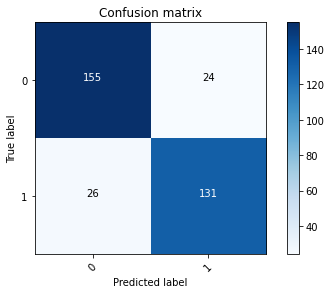

In [ ]:
model = models.load_model(os.path.join(MODEL_PATH, 'model_3d_4.h5'))
pred = model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])
cm = confusion_matrix(test_labels, np.rint(pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

## Error Analysis

Number of test images: 336
Mispredictions: 47


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


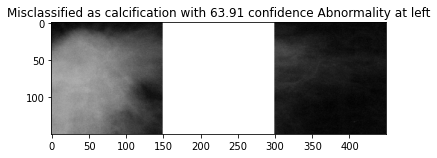

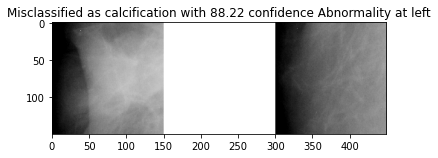

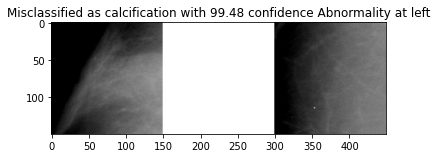

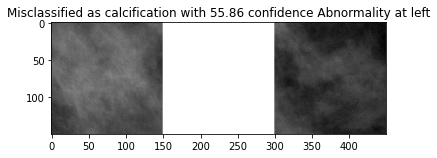

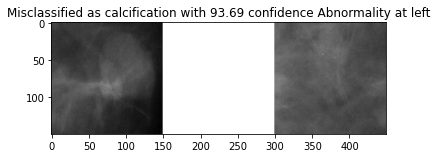

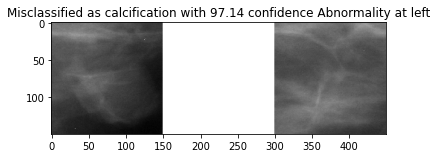

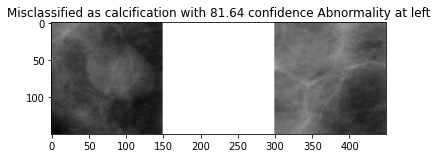

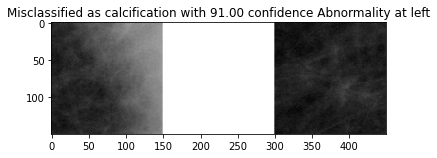

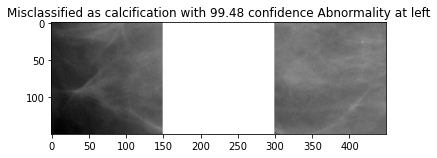

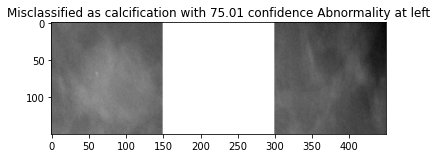

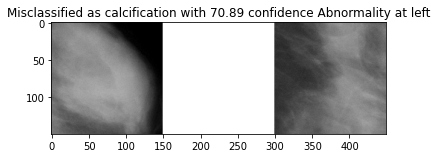

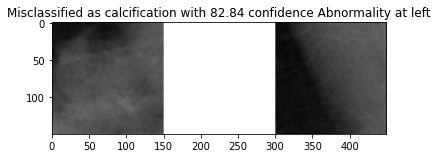

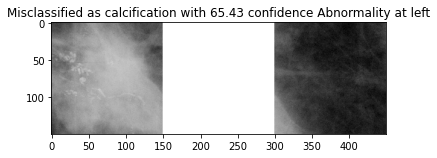

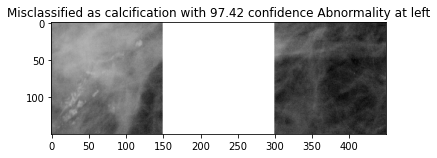

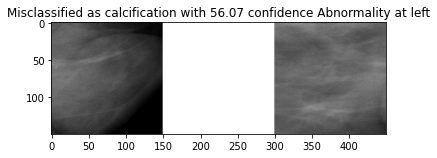

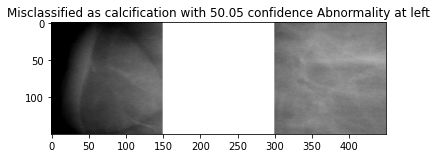

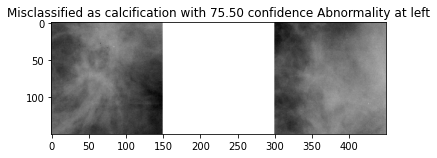

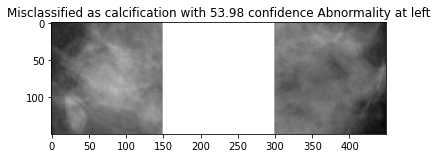

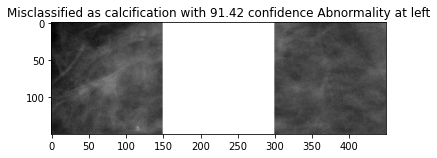

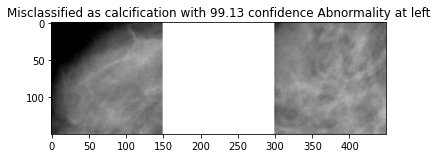

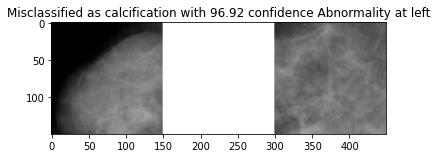

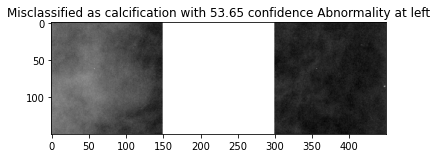

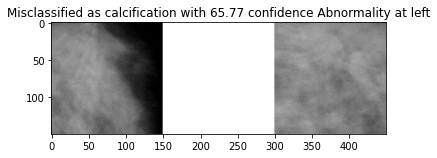

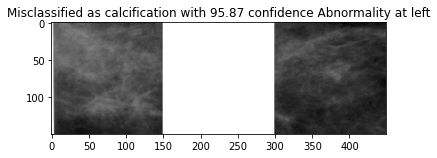

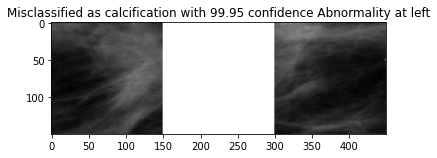

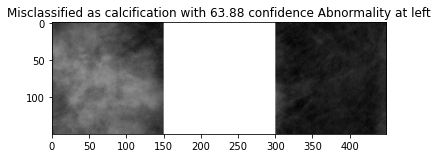

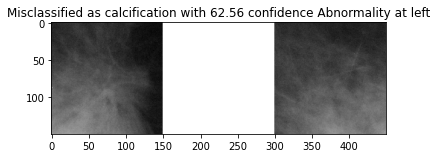

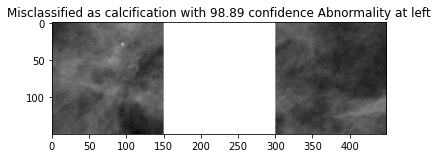

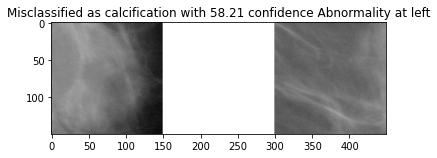

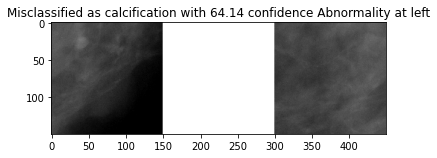

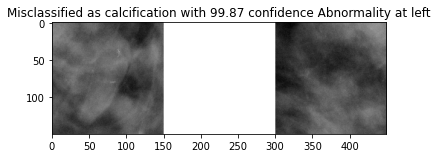

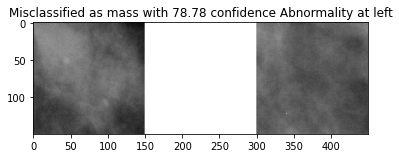

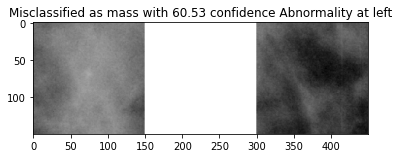

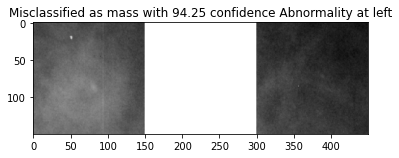

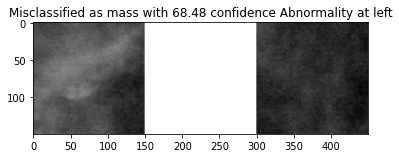

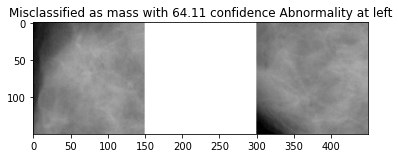

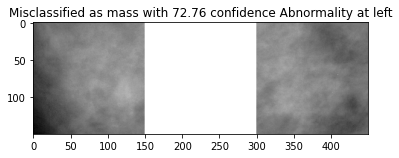

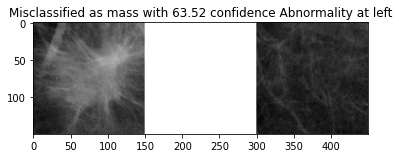

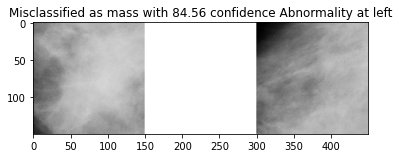

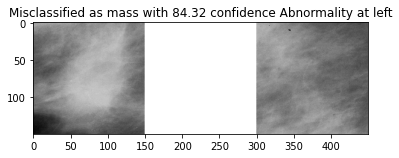

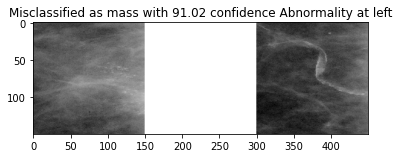

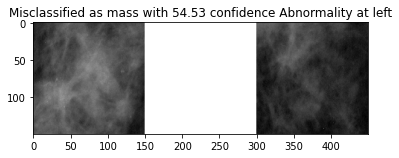

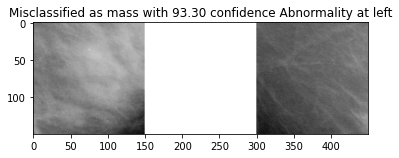

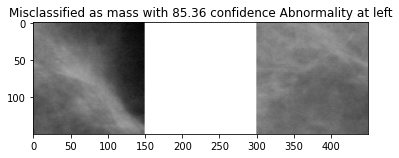

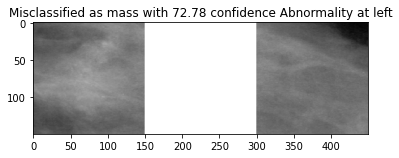

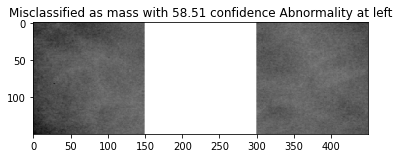

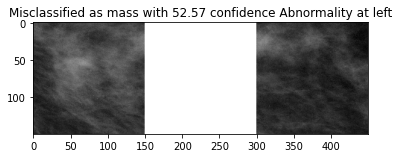

In [ ]:
import seaborn as sns

def get_errors(pred, test_label, test_data):
    errors = []
    mispred = []
    for l, p, images in zip(test_label, pred, test_data):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l, p, images))

    return errors, mispred

def show_error_stats(errors, mispred, test_data):

    print("Number of test images: %d" % test_data.shape[0])
    print("Mispredictions: %d" % len(mispred))
    for l, p, img in mispred:
        plt.figure()
        plt.imshow(np.hstack((img[:,:,0, 0], np.ones((150, 150)) , img[:,:,1, 0])), cmap='gray')
        
        plt.title('Misclassified as ' + ('mass' if l==1 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)) + ' Abnormality at left')
        #plt.axis('off')

opt_model = models.load_model(os.path.join(MODEL_PATH, 'model_3d.h5'))
pred_opt = opt_model.predict(np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])

errors, mispred = get_errors(pred_opt, test_labels, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])

show_error_stats(errors, mispred, np.stack((test_images[:,0,:,:,0], test_images[:,1,:,:,0]), axis=-1)[:,:,:,:,np.newaxis])